In [26]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib.pyplot import style
import mmcv
style.use('seaborn-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"


class RBF_Add(nn.Module):
    def __init__(self, add_rbf_number, device):
        super(RBF_Add, self).__init__()

        self.add_rbf_number = add_rbf_number
        self.radial_layer_centers_list = []
        self.radial_sigma_list = []
        self.linear_layer_weights_list = []
        
        
        self.total_radial_layer_centers_list = []
        self.total_radial_sigma_list = []
        self.total_linear_layer_weights_list = []
        
        self.change_th = 3

    def rbf_gaussian(self, input_data):
        output = torch.exp(-1 * (torch.pow((input_data - self.radial_layer_centers), 2) / \
                                 (torch.pow(self.radial_sigma, 2))))

        return output  # size = (num_rbf, 1)

    def done_rbf_gaussian(self, input_data, number):
        output = torch.exp(-1 * (torch.pow(
            (input_data - self.done_radial_layer_centers[number - 1 - self.add_rbf_number:number - 1]), 2) / \
                                 (torch.pow(self.done_radial_sigma[number - 1 - self.add_rbf_number:number - 1], 2))))

        return output  # size = (num_rbf, 1)

    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.radial_layer_centers) / \
                  (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_centers2(self, input_data):
        output = (2 / (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data) + \
                ((-2* (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * \
                 self.rbf_gaussian_derivative_centers(input_data))

        return output  # size = (num_radial, 1)

    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.radial_layer_centers), 2) / \
                  (torch.pow(self.radial_sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma2(self, input_data):
        output = (4 * (input_data - self.radial_layer_centers) / (torch.pow(self.radial_sigma, 3))) * \
                    self.rbf_gaussian(input_data) + (-2*(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)) * \
                    self.rbf_gaussian_derivative_sigma(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order=1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def Loss(self, pred, target, pred_grad, true_grad):
        
        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2))

    def forward(self, input_data):
        rbf_output = self.rbf_gaussian(input_data)
        pred = torch.mm(self.linear_layer_weights, rbf_output)

        return rbf_output, pred

    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_radial_layer_centers), 2) / \
                                     (torch.pow(self.done_radial_sigma, 2))))
        pred = torch.mm(self.done_linear_layer_weights, rbf_output)

        return rbf_output, pred
    
    def L2_F(self, input_data):
        return -2 * (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)
    

    def first_rbf_parameter(self, input_data, target):
        
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()
        find_sigma = target.clone().detach()
        
        target_std = target.std()
        
        find_weight = target.clone().detach()
        center_index_list = []

        for i in range(self.add_rbf_number):
            index_ = torch.argmax(torch.abs(fine_index_target)).cpu().detach().tolist()
            fine_index_target[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)
                            

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))
    
        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def init_rbf_parameter(self, input_data, error):
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        target_std = error.std()
        center_index_list = []

        for i in range(self.add_rbf_number * (self.change_time + 1)):
            index_ = torch.argmax(torch.abs(find_index_error)).cpu().detach().tolist()

            find_index_error[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft =  (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))

        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1

    def best_forward(self, input_data, best_center, best_sigma, best_weight):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                     (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return rbf_output, pred    
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * radial_output

    def backward_propagation(self, input_data, radial_output, pred, target, target_grad, pred_grad):
        
        L2_1_error = -2 * (target - pred)
        L2_2_error = -2 * (target_grad - pred_grad)
        
        len_ = len(L2_2_error)

        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error
        deltaSigma1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        
        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error
        deltaSigma2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        deltaSigma =  torch.sum(deltaSigma1, dim=1) + torch.sum(deltaSigma2, dim=1)

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error
        deltaCenter1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        
        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error
        deltaCenter2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        deltaCenter =  torch.sum(deltaCenter1, dim=1) + torch.sum(deltaCenter2, dim=1)

        # weight update
        delta_weight1 = torch.sum((radial_output * L2_1_error), dim=1)
        delta_weight1 = delta_weight1.reshape(1, self.add_rbf_number)
        
        delta_weight2 = torch.sum((self.L2_2_derivateive_weight(input_data, radial_output) * L2_2_error), dim = 1)
        delta_weight2 = delta_weight2.reshape(1, self.add_rbf_number)
        delta_weight = delta_weight1 + delta_weight2
        
        # BP update
        self.linear_layer_weights -= self.lr * delta_weight
        self.radial_layer_centers -= self.lr * deltaCenter.reshape(self.add_rbf_number, 1)
        self.radial_sigma -= self.lr * deltaSigma.reshape(self.add_rbf_number, 1)
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr

        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.change_time = 0
        self.round_number = 5
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.lr_change_th = lr_change_th
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_number
        loss = 100000

        while self.loss_th < loss:
            print(self.number)
            # first rbf
            if self.number == 0:
                cent, weig, sig = self.first_rbf_parameter(input_data, self.target[0])
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)
                first_grad = self.first_grad(input_data, target)
                for epo in range(epochs):
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    self.backward_propagation(input_data, radial_output, pred, self.target, first_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, first_grad)
                    if epo == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    else:
                        if self.best_loss > epo_loss:
                            self.best_loss = epo_loss.clone().detach()
                            self.best_center = self.radial_layer_centers.clone().detach()
                            self.best_sigma = self.radial_sigma.clone().detach()
                            self.best_weight = self.linear_layer_weights.clone().detach()
                    if (epo + 1) % 250 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

            # additional rbf
            else:
                # init parameter
                self.change_init(na)
                if self.change_time > break_time:
                    break
                cent, weig, sig = self.init_rbf_parameter(input_data, self.target[0])
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)

                for epo in range(epochs):
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    
                    if epo == 0:
                        print(self.Loss(pred, self.target, rbf_grad, target_grad))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
                    self.backward_propagation(input_data, radial_output, pred, self.target, target_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epo + 1) % 1000 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

                    # best parameter
                    if self.best_loss > epo_loss:
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
            radial_output, best_pred = self.best_forward(input_data, self.best_center, self.best_sigma,
                                                         self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print('train_loss', train_loss)
            print("best loss : ", self.best_loss)

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')

            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')

            self.train_loss_list.append(torch.round(train_loss * (10 ** self.round_number)) / 10 ** self.round_number)

            # additional rbf plot print
            plt.figure(figsize=(20, 10))
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.radial_layer_centers_list.append(self.best_center)
                self.radial_sigma_list.append(self.best_sigma)
                self.linear_layer_weights_list.append(self.best_weight)

                self.done_radial_layer_centers = torch.cat(self.radial_layer_centers_list, 0)
                self.done_radial_sigma = torch.cat(self.radial_sigma_list, 0)
                self.done_linear_layer_weights = torch.cat(self.linear_layer_weights_list, 1)
                target_grad = self.target_grad(input_data, self.done_radial_layer_centers, self.done_radial_sigma, self.done_linear_layer_weights, first_grad)
            else:
                na = 0

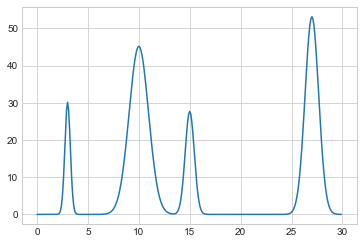

In [27]:
C = torch.tensor([[3], [10], [15],[27]], dtype = float, device = device)
S = torch.tensor([[0.2669],[0.9528],[0.4450],[0.6691]], device='cuda:0', dtype=torch.float64)
W = torch.tensor([[30.123, 45.1631, 27.672, 53.124]], device='cuda:0',dtype=torch.float64)

def data_gen(input_):
    output =torch.exp(-1 * (torch.pow(input_ - C, 2) / \
                                (2 * torch.pow(S, 2))))
    return output # size = (num_rbf, 1)

def data_gradient(x, center_list, sigma_list, weight_list):
    rbf_output = (-1 * (x-center_list) / torch.pow(sigma_list,2)) * (torch.exp(-1 * (torch.pow((x - center_list), 2) / (2 * torch.pow(sigma_list, 2)))))
    rbf_grad = torch.mm(weight_list, rbf_output)
    
    return rbf_grad

def rbf_gradient(x, center_list, sigma_list, weight_list):
    rbf_output = (-2 * (x-center_list) / torch.pow(sigma_list,2)) * (torch.exp(-1 * (torch.pow((x - center_list), 2) / (torch.pow(sigma_list, 2)))))
    rbf_grad = torch.mm(weight_list, rbf_output)
    
    return rbf_grad

input_ = torch.tensor([i/10 for i in range(300)], dtype = float, device = device)
target2 = torch.mm(W, data_gen(input_))
gr = rbf_gradient(input_, C, S, W)
plt.plot(input_.cpu().detach().numpy(), target2[0].cpu().detach().numpy())

0
0 epoch MSE Loss: 128377.18828217557
249 epoch MSE Loss: 8093.060411252779
499 epoch MSE Loss: 802.4274960168594
749 epoch MSE Loss: 477.36029264357177
999 epoch MSE Loss: 456.2295952874593
1249 epoch MSE Loss: 445.747720764221
1499 epoch MSE Loss: 437.4891460209572
1749 epoch MSE Loss: 430.4653142356111
1999 epoch MSE Loss: 424.24244367016456
2249 epoch MSE Loss: 418.58416710699487
2499 epoch MSE Loss: 413.34913598765274
2749 epoch MSE Loss: 408.44188120059476
2999 epoch MSE Loss: 403.7906249693081
3249 epoch MSE Loss: 399.3393699812345
3499 epoch MSE Loss: 395.04749722796157
3749 epoch MSE Loss: 390.880110693609
3999 epoch MSE Loss: 386.8063845099511
4249 epoch MSE Loss: 382.81311275082487
4499 epoch MSE Loss: 378.8926898969885
4749 epoch MSE Loss: 375.0214392637447
4999 epoch MSE Loss: 371.1972621149024
train_loss tensor(371.1933, device='cuda:0', dtype=torch.float64)
best loss :  tensor(371.1973, device='cuda:0', dtype=torch.float64)


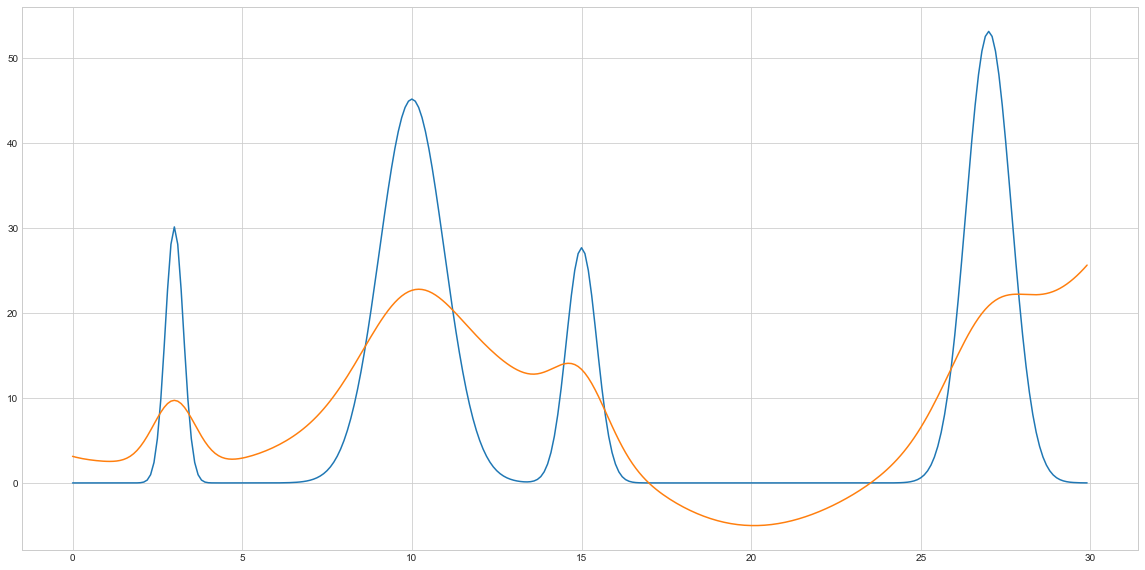

1
tensor(18378.4795, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 156.45782030435865
1999 epoch MSE Loss: 126.46238551789445
2999 epoch MSE Loss: 97.29483698750073
3999 epoch MSE Loss: 107.27770552416116
4999 epoch MSE Loss: 98.35758441418272
train_loss tensor(91.7444, device='cuda:0', dtype=torch.float64)
best loss :  tensor(91.7441, device='cuda:0', dtype=torch.float64)


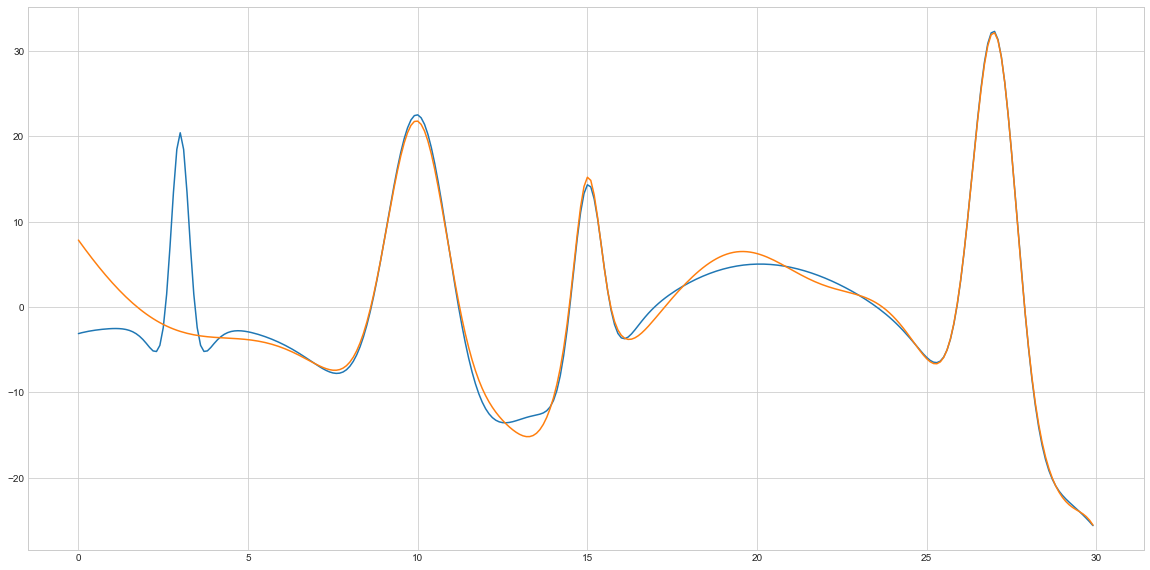

2
tensor(1490.0513, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 36.869841542402355
1999 epoch MSE Loss: 65.93010564509949
2999 epoch MSE Loss: 45.188857345989895
3999 epoch MSE Loss: 32.01198424153565
4999 epoch MSE Loss: 23.24691008883879
train_loss tensor(23.2397, device='cuda:0', dtype=torch.float64)
best loss :  tensor(23.2469, device='cuda:0', dtype=torch.float64)


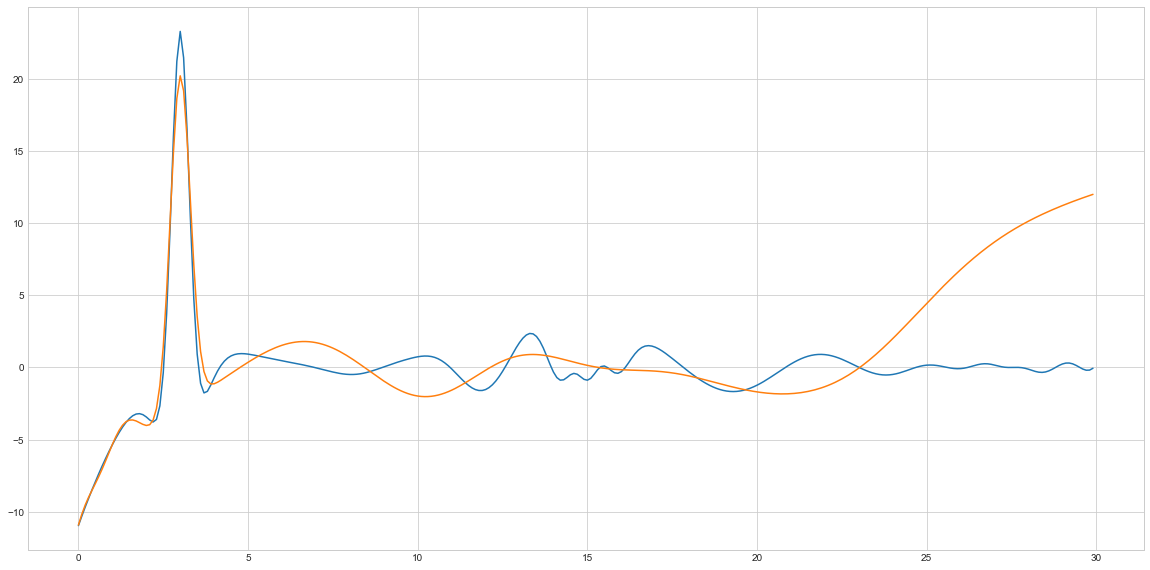

3
tensor(16521.4109, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 58.84431507824812
1999 epoch MSE Loss: 23.35012678606772
2999 epoch MSE Loss: 14.906777820661732
3999 epoch MSE Loss: 12.187308986813457
4999 epoch MSE Loss: 9.98912834355686
train_loss tensor(9.9881, device='cuda:0', dtype=torch.float64)
best loss :  tensor(9.9891, device='cuda:0', dtype=torch.float64)
change lr  9.999999999999999e-06
----------------------------------------------


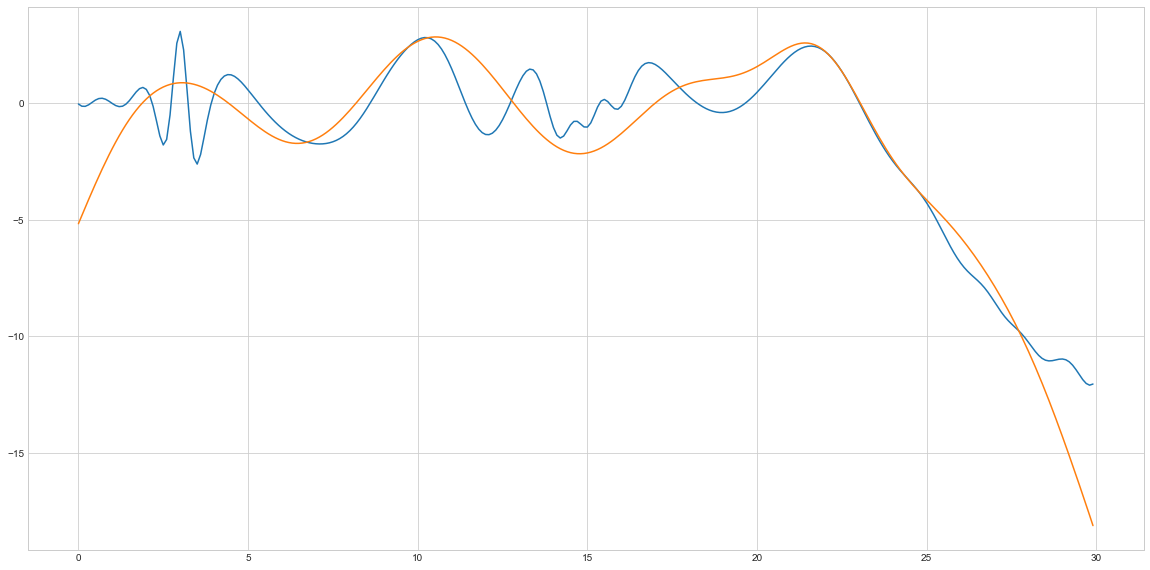

4
tensor(271.3862, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 6.930183462636949
1999 epoch MSE Loss: 7.185836747644492
2999 epoch MSE Loss: 7.203553993783455
3999 epoch MSE Loss: 6.645659002204258
4999 epoch MSE Loss: 6.748353601214752
train_loss tensor(4.9634, device='cuda:0', dtype=torch.float64)
best loss :  tensor(4.9634, device='cuda:0', dtype=torch.float64)


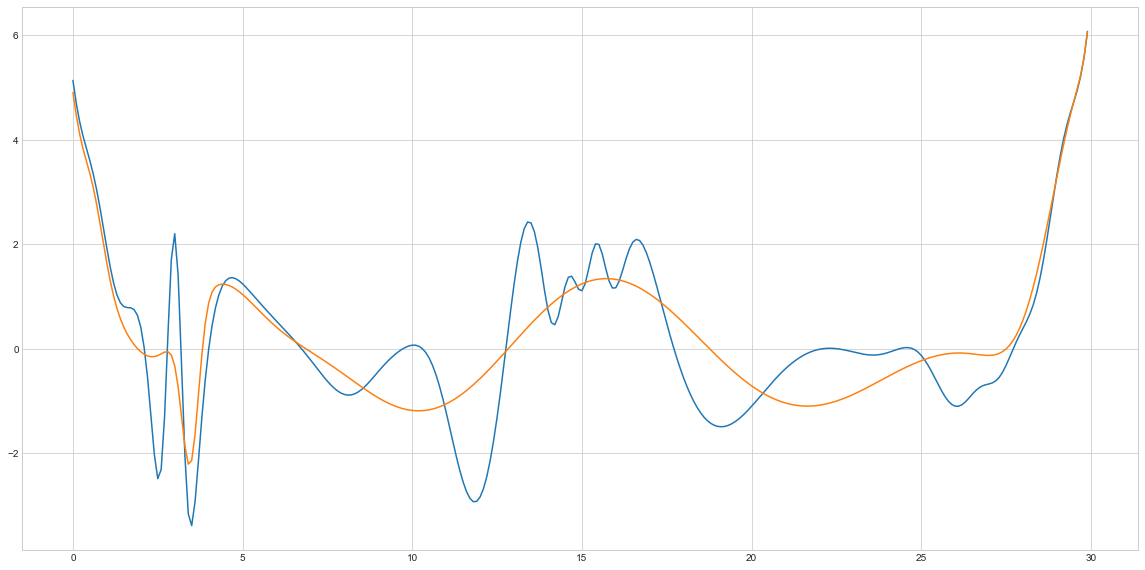

5
tensor(102.8548, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 2.513165544361538
1999 epoch MSE Loss: 1.905279633663723
2999 epoch MSE Loss: 0.9778862070003541
3999 epoch MSE Loss: 0.6818948014598706
4999 epoch MSE Loss: 2.907126796129916
train_loss tensor(0.5561, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.5561, device='cuda:0', dtype=torch.float64)
change lr  9.999999999999999e-05
----------------------------------------------


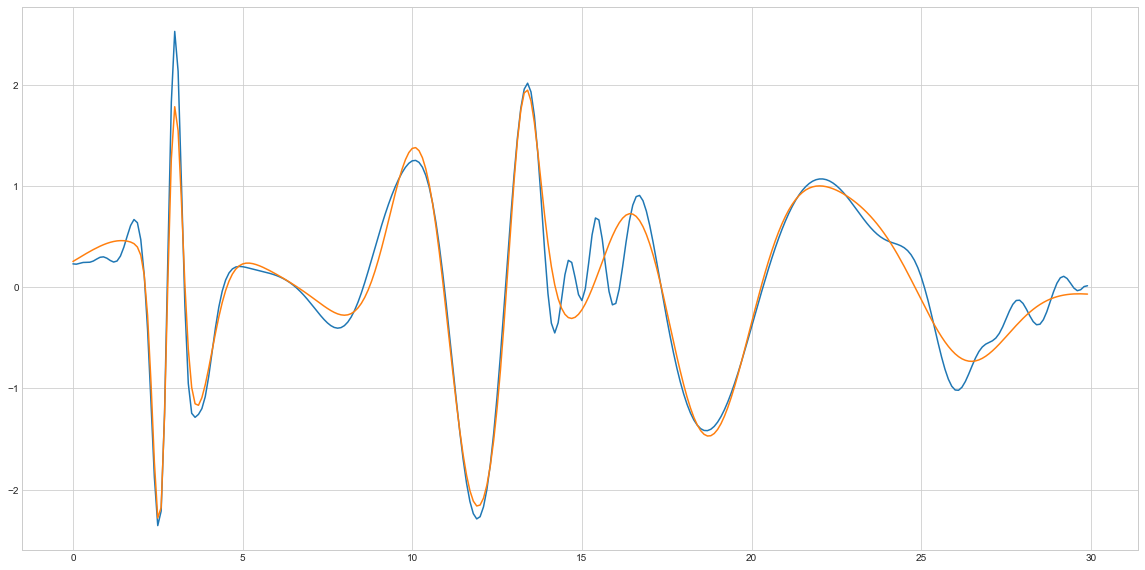

6
tensor(2.4598, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.13036530791531525
1999 epoch MSE Loss: 0.11893641865430452
2999 epoch MSE Loss: 0.10503498345082841
3999 epoch MSE Loss: 0.09716710098623013
4999 epoch MSE Loss: 0.09804277890374588
train_loss tensor(0.0965, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0965, device='cuda:0', dtype=torch.float64)
change round number 6
----------------------------------------------


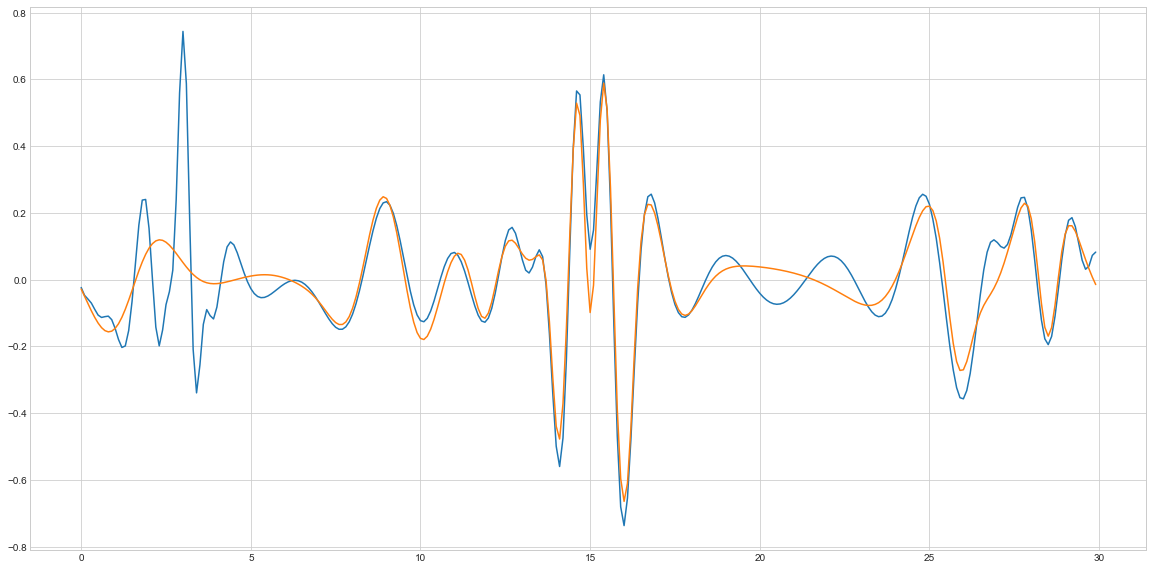

79.73548 sec


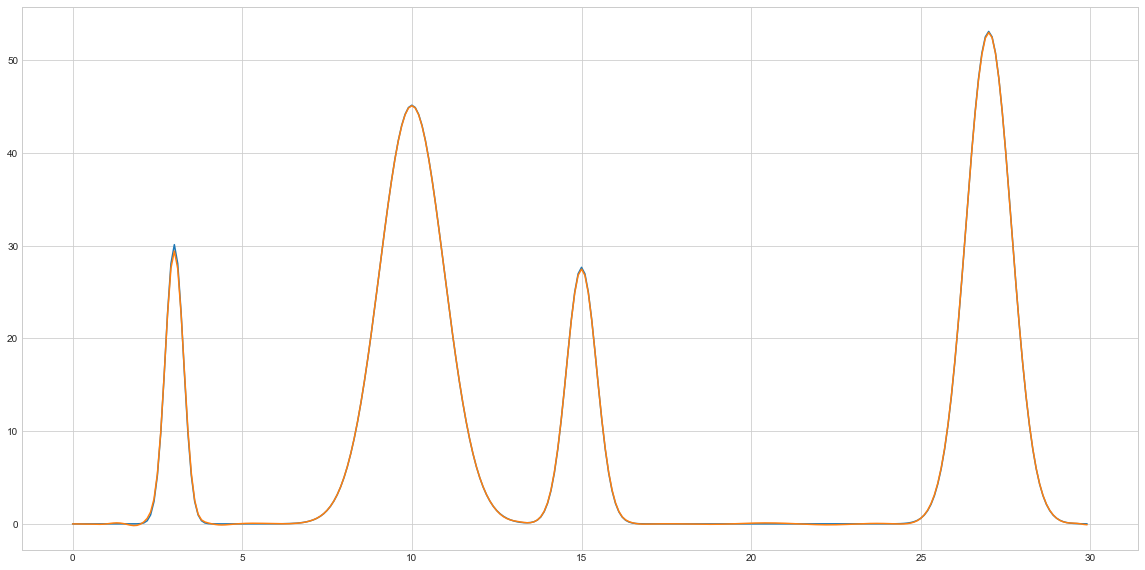

In [28]:
start = time.time()
model2 = RBF_Add(100, device)
model2.train(input_, target2, 5000, 1e-06, 0.1, 20)
end = time.time()
print(f"{end - start:.5f} sec")

plt.figure(figsize=(20,10))
plt.plot(input_.cpu().detach().numpy(), target2[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model2.pred(input_)[1][0].cpu().detach().numpy())
rbf_grad2 = rbf_gradient(input_, model2.done_radial_layer_centers, model2.done_radial_sigma, model2.done_linear_layer_weights)

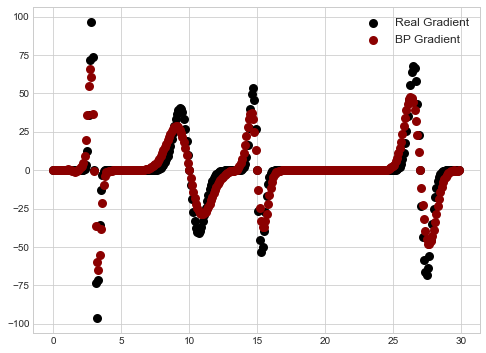

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(input_.cpu().detach().numpy(), gr.cpu().detach().numpy(),label='Real Gradient', linewidths = 3.0, color = 'black',zorder=2)
plt.scatter(input_.cpu().detach().numpy(), rbf_grad2[0].cpu().detach().numpy(),label='BP Gradient', linewidths = 3.0, color = 'darkred',zorder=2)
plt.legend(fontsize = 12,facecolor='gray',edgecolor='black',fancybox=True)
plt.show()

In [30]:
print('BP fitting loss:',torch.mean(torch.abs(target2 - model2.pred(input_)[1])))
print('BP gradient loss:',torch.mean(torch.abs(gr - rbf_grad2[0])))

BP fitting loss: tensor(0.0566, device='cuda:0', dtype=torch.float64)
BP gradient loss: tensor(5.3075, device='cuda:0', dtype=torch.float64)


In [18]:
print('BP fitting loss:',torch.mean(torch.abs(target2 - model2.pred(input_)[1])))
print('BP gradient loss:',torch.mean(torch.abs(gr - rbf_grad2[0])))

BP fitting loss: tensor(0.0437, device='cuda:0', dtype=torch.float64)
BP gradient loss: tensor(5.3004, device='cuda:0', dtype=torch.float64)


In [8]:
coordinates = (torch.tensor([-2., -1., 1., 4.]),)
values = torch.tensor([4., 1., 1., 16.], )
torch.gradient(values, spacing = coordinates)

(tensor([-3., -2.,  2.,  5.]),)

In [13]:
torch.gradient(values, spacing = coordinates, edge_order  = 2)

(tensor([-4., -2.,  2.,  8.]),)

In [19]:
input__ = (input_,)

In [31]:
torch.gradient(target2[0], spacing = input__, edge_order  = 1)[0]

tensor([ 1.0900e-21,  2.3256e-21,  1.5262e-20,  3.9052e-19,  1.3409e-17,
         4.1634e-16,  1.1269e-14,  2.6512e-13,  5.4197e-12,  9.6269e-11,
         1.4857e-09,  1.9920e-08,  2.3201e-07,  2.3472e-06,  2.0621e-05,
         1.5730e-04,  1.0414e-03,  5.9825e-03,  2.9800e-02,  1.2862e-01,
         4.8052e-01,  1.5516e+00,  4.3215e+00,  1.0350e+01,  2.1216e+01,
         3.6958e+01,  5.4030e+01,  6.4752e+01,  6.0326e+01,  3.6869e+01,
         7.2640e-10, -3.6869e+01, -6.0326e+01, -6.4752e+01, -5.4030e+01,
        -3.6958e+01, -2.1216e+01, -1.0350e+01, -4.3215e+00, -1.5516e+00,
        -4.8052e-01, -1.2862e-01, -2.9797e-02, -5.9774e-03, -1.0321e-03,
        -1.4049e-04,  9.3837e-06,  5.0630e-05,  9.2253e-05,  1.5961e-04,
         2.7242e-04,  4.5964e-04,  7.6673e-04,  1.2645e-03,  2.0617e-03,
         3.3232e-03,  5.2956e-03,  8.3421e-03,  1.2991e-02,  1.9998e-02,
         3.0430e-02,  4.5770e-02,  6.8048e-02,  9.9995e-02,  1.4523e-01,
         2.0846e-01,  2.9572e-01,  4.1457e-01,  5.7

In [23]:
torch.gradient(target2[0], spacing = input__, edge_order  = 2)[0]

tensor([-1.4558e-22,  2.3256e-21,  1.5262e-20,  3.9052e-19,  1.3409e-17,
         4.1634e-16,  1.1269e-14,  2.6512e-13,  5.4197e-12,  9.6269e-11,
         1.4857e-09,  1.9920e-08,  2.3201e-07,  2.3472e-06,  2.0621e-05,
         1.5730e-04,  1.0414e-03,  5.9825e-03,  2.9800e-02,  1.2862e-01,
         4.8052e-01,  1.5516e+00,  4.3215e+00,  1.0350e+01,  2.1216e+01,
         3.6958e+01,  5.4030e+01,  6.4752e+01,  6.0326e+01,  3.6869e+01,
         7.2640e-10, -3.6869e+01, -6.0326e+01, -6.4752e+01, -5.4030e+01,
        -3.6958e+01, -2.1216e+01, -1.0350e+01, -4.3215e+00, -1.5516e+00,
        -4.8052e-01, -1.2862e-01, -2.9797e-02, -5.9774e-03, -1.0321e-03,
        -1.4049e-04,  9.3837e-06,  5.0630e-05,  9.2253e-05,  1.5961e-04,
         2.7242e-04,  4.5964e-04,  7.6673e-04,  1.2645e-03,  2.0617e-03,
         3.3232e-03,  5.2956e-03,  8.3421e-03,  1.2991e-02,  1.9998e-02,
         3.0430e-02,  4.5770e-02,  6.8048e-02,  9.9995e-02,  1.4523e-01,
         2.0846e-01,  2.9572e-01,  4.1457e-01,  5.7

In [32]:
print('Difference between Real gradient and Estimation gradient')
print(torch.mean(torch.abs(torch.gradient(target2[0], spacing = (input_,), edge_order  = 1)[0] - gr)))
print(torch.mean(torch.abs(torch.gradient(target2[0], spacing = (input_,), edge_order  = 2)[0] - gr)))

Difference between Real gradient and Estimation gradient
tensor(5.2610, device='cuda:0', dtype=torch.float64)
tensor(5.2609, device='cuda:0', dtype=torch.float64)


In [25]:
torch.mean(torch.abs(torch.gradient(target2[0], spacing = input__, edge_order  = 1)[0] - gr))

tensor(5.2610, device='cuda:0', dtype=torch.float64)

In [24]:
torch.mean(torch.abs(torch.gradient(target2[0], spacing = input__, edge_order  = 2)[0] - gr))

tensor(5.2609, device='cuda:0', dtype=torch.float64)